In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# 폰트
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False
path = '/content/drive/MyDrive/colab전용/malgun.ttf'
fontprop = fm.FontProperties(fname=path, size=8)

# 진행상황
from IPython.display import display
from tqdm import tqdm

# ts
from datetime import datetime,date
from fbprophet import Prophet
import holidays

In [204]:
train=pd.read_csv('/content/drive/MyDrive/colab전용/open_data/train.csv',encoding='cp949')
submission=pd.read_csv('/content/drive/MyDrive/colab전용/open_data/submission.csv',encoding='cp949')

In [205]:
train['DateTime']=pd.to_datetime(train['DateTime'])

train=train.set_index('DateTime')
train=train.resample('D').sum()

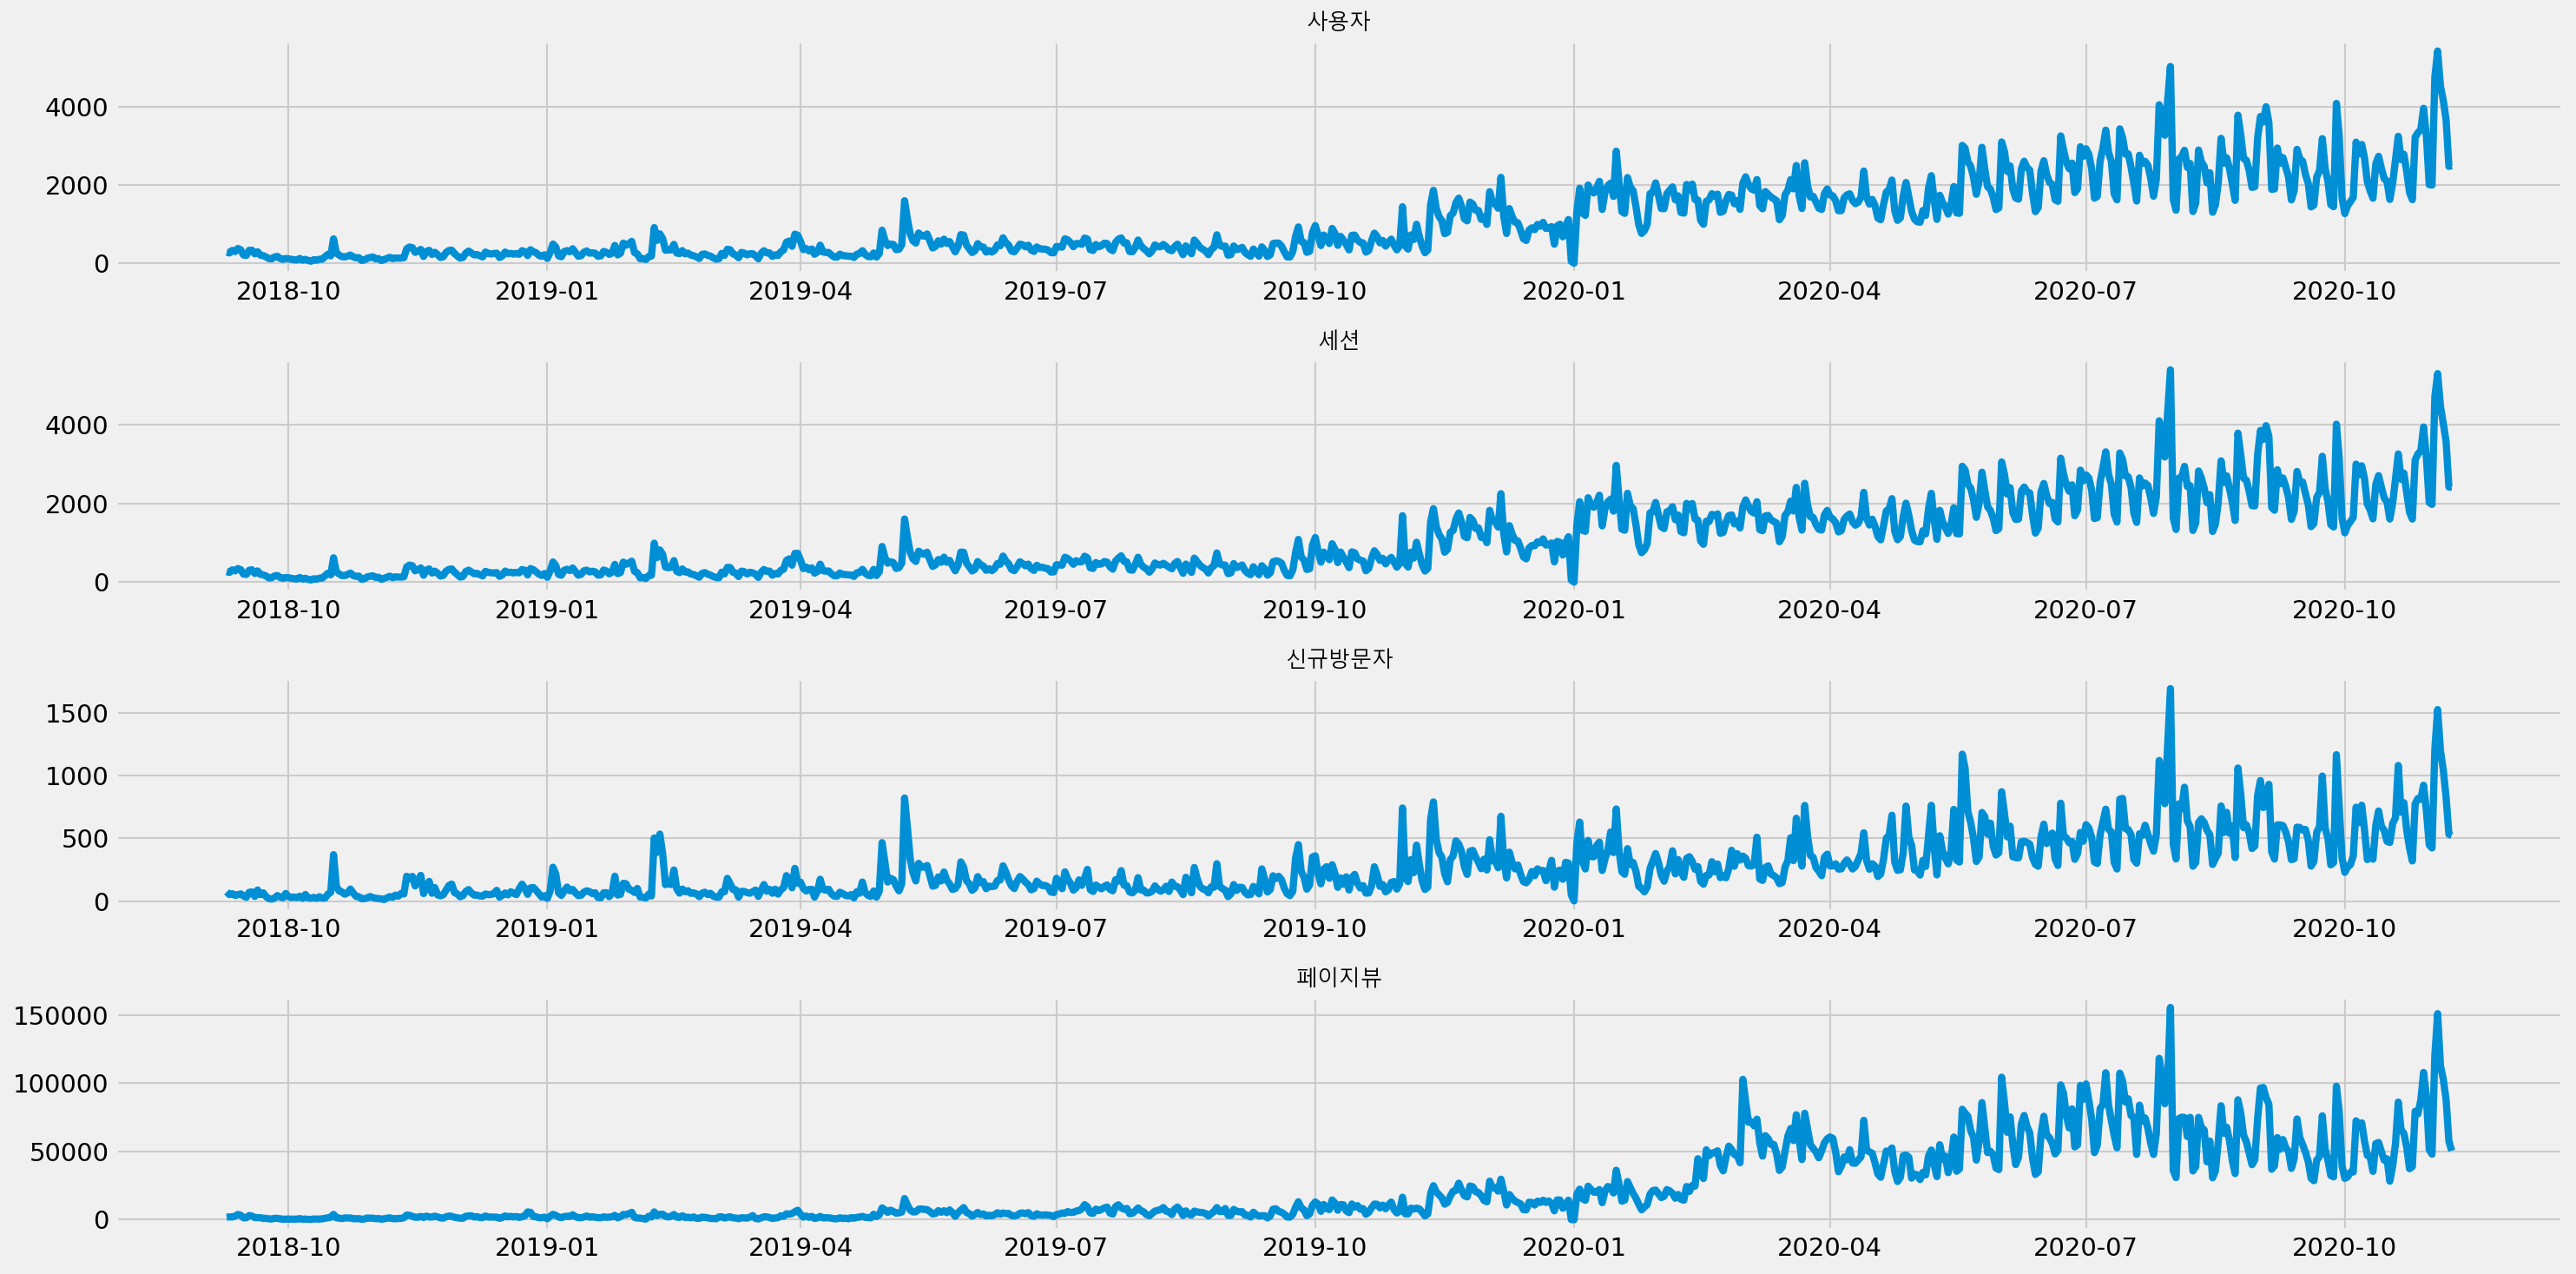

In [206]:
# 경향성.
fig,axs=plt.subplots(4,1,figsize=(20,10),dpi=150)

for idx,col in enumerate(train.columns):
    df=train[col]
    axs[idx].plot(df)
    axs[idx].set_title(f"{col}",fontproperties=fontprop,fontsize=12)
plt.tight_layout()
plt.show()

In [207]:
# 증가폭이 있는 2019년 10월 부터 시작.
train=train.loc[train.index>=datetime(2019,10,1)]

train=train.reset_index()

In [208]:
user=pd.DataFrame({
    'ds':train.DateTime,
    'y':train.사용자
})
session=pd.DataFrame({
    'ds':train.DateTime,
    'y':train.세션
})
visitor=pd.DataFrame({
    'ds':train.DateTime,
    'y':train.신규방문자
})
view=pd.DataFrame({
    'ds':train.DateTime,
    'y':train.페이지뷰
})

In [209]:
m1=Prophet()
m1.fit(user)

user_future=m1.make_future_dataframe(periods=61,freq='D')
user_future.tail()

user_forecast=m1.predict(user_future)
user_forecast[['ds','yhat','yhat_upper','yhat_lower']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_upper,yhat_lower
461,2021-01-04,3490.073424,4111.312302,2898.756316
462,2021-01-05,3455.893261,4051.284916,2835.877595
463,2021-01-06,3320.674111,3942.599362,2750.665832
464,2021-01-07,3295.458827,3910.866351,2690.503253
465,2021-01-08,3192.872994,3827.135476,2533.176782


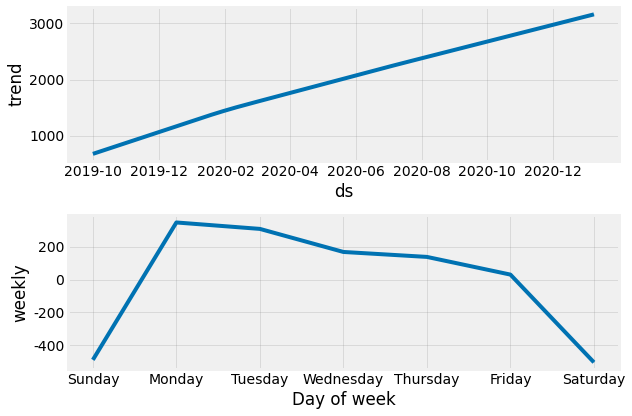

In [210]:
# 당연했지만, 주말은 참여가 많이 적다.
# weekly trend가 있다.
m1.plot_components(user_forecast);

In [211]:
m1=Prophet()
m1.fit(user)

user_future=m1.make_future_dataframe(periods=61,freq='D')
user_future.tail()

user_forecast=m1.predict(user_future)
user_forecast[['ds','yhat','yhat_upper','yhat_lower']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_upper,yhat_lower
461,2021-01-04,3490.073424,4098.911506,2885.124109
462,2021-01-05,3455.893261,4115.092495,2835.053563
463,2021-01-06,3320.674111,3944.892843,2685.342077
464,2021-01-07,3295.458827,3906.762007,2641.300087
465,2021-01-08,3192.872994,3821.384239,2498.518545


In [212]:
# 최적화 값. 
# 마지막 흐름을 보면. 예측값의 upper 부분이 평일이랑 비슷하고
# 예측값의 median 부분. yhat이랑 주말이 비슷하다. 그래서 최적화값으로 upper과 yhat을 섞었다.

korea=holidays.Korea()

start=datetime(2020,11,9)
end=datetime(2021,1,8)

df=pd.DataFrame()
df['ds']=pd.date_range(start,end)

bdates=pd.bdate_range(start,end)
for idx,day in enumerate(df['ds']):
    df.loc[idx,'day']=day.weekday()
display(df.head(10))

,ds,day
0,2020-11-09,0.0
1,2020-11-10,1.0
2,2020-11-11,2.0
3,2020-11-12,3.0
4,2020-11-13,4.0
5,2020-11-14,5.0
6,2020-11-15,6.0
7,2020-11-16,0.0
8,2020-11-17,1.0
9,2020-11-18,2.0


In [213]:
user_forecast=user_forecast.loc[405:,['ds','yhat','yhat_upper']]
user_forecast=pd.merge(user_forecast,df,on='ds')

user_forecast['pred']=user_forecast.apply(lambda row:row.yhat_upper if row.day<6 else row.yhat,axis=1)

In [214]:
submission['사용자']=user_forecast['pred']
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3841.071967,0,0,0
1,2020-11-10,3810.749586,0,0,0
2,2020-11-11,3655.999823,0,0,0
3,2020-11-12,3665.963634,0,0,0
4,2020-11-13,3526.824451,0,0,0


In [216]:
# 세션
m2=Prophet(seasonality_prior_scale=0.1,interval_width=0.9)
m2.fit(session)

session_future=m2.make_future_dataframe(periods=61)

session_forecast=m2.predict(session_future)

session_forecast=session_forecast.loc[405:,['ds','yhat','yhat_upper']]
session_forecast=pd.merge(session_forecast,df,on='ds')

session_forecast['pred']=session_forecast.apply(lambda row:row.yhat_upper if row.day<6 else row.yhat,axis=1)

submission['세션']=session_forecast['pred']

# 신규방문자
m3=Prophet(seasonality_prior_scale=0.1,interval_width=0.9)
m3.fit(visitor)

visitor_future=m3.make_future_dataframe(periods=61)

visitor_forecast=m3.predict(visitor_future)

visitor_forecast=visitor_forecast.loc[405:,['ds','yhat','yhat_upper']]
visitor_forecast=pd.merge(visitor_forecast,df,on='ds')

visitor_forecast['pred']=visitor_forecast.apply(lambda row:row.yhat_upper if row.day<6 else row.yhat,axis=1)

submission['신규방문자']=visitor_forecast['pred']

# 페이지뷰
m4=Prophet(seasonality_prior_scale=0.1,interval_width=0.9)
m4.fit(view)

view_future=m4.make_future_dataframe(periods=61)

view_forecast=m4.predict(view_future)

view_forecast=view_forecast.loc[405:,['ds','yhat','yhat_upper']]
view_forecast=pd.merge(view_forecast,df,on='ds')

view_forecast['pred']=view_forecast.apply(lambda row:row.yhat_upper if row.day<6 else row.yhat,axis=1)

submission['페이지뷰']=view_forecast['pred']

# 확인
submission.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3841.071967,4049.777129,1063.533692,99198.680501
1,2020-11-10,3810.749586,3913.987298,1056.034731,97115.501626
2,2020-11-11,3655.999823,3805.602048,992.175352,95918.287469
3,2020-11-12,3665.963634,3845.799477,984.931957,93084.205682
4,2020-11-13,3526.824451,3689.235046,986.525877,90130.217601


In [218]:
# submission.to_csv('/content/drive/MyDrive/colab전용/prophet_20210114.csv',index=False,encoding='euc-kr')